In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import regex as re
import math
from collections import Counter

from google.colab import files
import zipfile
import glob

from brat_parser import get_entities_relations_attributes_groups

from nltk.tag import pos_tag, map_tag

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from scipy.stats import spearmanr

# **Dataset import**

In [ ]:
# Import the claims positions in the articles (claim-positions.txt).
print("\nImport claim-positions.txt:\n")
uploaded = files.upload()

# Import the premise positions in the articles (premise-positions.txt).
print("\nImport premise-positions.txt:\n")
uploaded = files.upload()

# Import the POS tag to use in the POS BOW (claim_premise_original_POS.txt).
print("\nImport claim_premise_POS.txt:\n")
uploaded = files.upload()

# Import the simple POS tag to use in the simple POS BOW (claim_premise_original_simple_POS.txt).
print("\nImport claim_premise_simple_POS.txt:\n")
uploaded = files.upload()

# Import the POS tags bigrams to consider in the POS bigrams BOW (claim_premise_50_bigram_POS.txt).
print("\nImport claim_premise_50_bigram_POS.txt:\n")
uploaded = files.upload()

# Import the simple POS tags bigrams to consider in the simple POS bigrams BOW (claim_premise_50_bigram_simple_POS.txt).
print("\nImport claim_premise_50_bigram_simple_POS.txt:\n")
uploaded = files.upload()

# Import the dependency tags to consider in the dependency tag BOW (claim_premise_dependency_tag.txt).
print("\nImport claim_premise_dependency_tag.txt:\n")
uploaded = files.upload()

# Import the labeled named entity to consider in the dependency tag BOW(dependency_tag.txt).
print("\nImport claim_premise_labeled_named_entity.txt:\n")
uploaded = files.upload()

# Import the data relative to the sentences positions and statistics obtained considering the argumentative sections
# (sentence_statistic.csv).
print('\nImport Debater_sentence_statistic.csv\n')
upload = files.upload()

# Import the data relative to the statistic about the sentences dependency trees obtained considering the argumentative sections
# (Debater_sentence_dependency_tree_stat.csv).
print('\nImport Debater_sentence_dependency_tree_stat.csv\n')
upload = files.upload()

# Import the previously created BOW of the premise\claim of the corpus of the current dataset, using only the words that resulted the most correlated
# to the labels in the original dataset (Debater_claim_premise_BOW.csv).
print('\nImport Debater_claim_premise_BOW.csv\n')
upload = files.upload()

# Import the previously created bigrams' BOW of the premise\claim corpus of the current dataset, using only the bigrams that resulted the most correlated
# to the labels in the original dataset (Debater_claim_premise_Bigram.csv).
print('\nImport Debater_claim_premise_Bigram.csv\n')
upload = files.upload()

# Import the text file previously produced containing the prediction scores
# of the subjectivity of each sentence in the dataset (subj_obj_Debater.txt).
print("\nImport subj_obj_Debater.txt:\n")
subjectivity_uploaded = files.upload()

# Import the dataframe previously produced containing the BOW on the dataset of 
# the n-grams indicated in the appendix of the guidelines of the Stab and Gurevych 
# dataset (2017 version) as indicative of an argumentative sections (claim or premise).
#(file: Debater_BOW_appendix_words.cvs)
print('\nImport Debater_BOW_appendix_words.cvs\n')
upload = files.upload()


Import claim-positions.txt:



Saving claim-positions.txt to claim-positions.txt

Import premise-positions.txt:



Saving premise-positions.txt to premise-positions.txt

Import claim_premise_POS.txt:




Import claim_premise_simple_POS.txt:




Import claim_premise_50_bigram_POS.txt:




Import claim_premise_50_bigram_simple_POS.txt:




Import claim_premise_dependency_tag.txt:




Import claim_premise_labeled_named_entity.txt:




Import Debater_sentence_statistic.csv




Import Debater_sentence_dependency_tree_stat.csv




Import Debater_claim_premise_BOW.csv




Import Debater_claim_premise_Bigram.csv




Import subj_obj_Debater.txt:




Import Debater_BOW_appendix_words.cvs



In [ ]:
# Import the IBM Debater dataset.

uploaded = files.upload()

Saving IBM_Debater_(R)_CE-EMNLP-2015.v3.zip to IBM_Debater_(R)_CE-EMNLP-2015.v3.zip


In [ ]:
# Extract a zip file.
def import_zip(source: str, destination =""):
  with zipfile.ZipFile(source, 'r') as zip_ref:
    zip_ref.extractall(destination)


In [ ]:
# Extract the dataset.
import_zip("IBM_Debater_(R)_CE-EMNLP-2015.v3.zip")

# **Claim and premise extraction**

In [ ]:
# Read the files containing the labeled claim and premises.
claim_data=open("claim-positions.txt").read()
premise_data=open("premise-positions.txt").read()

In [ ]:
# Create a list which contains as elements the lines in the original document.
claim_lines=claim_data.split("\n")
premise_lines=premise_data.split("\n")

In [ ]:
# Separate each line of the document passed at the character '\t'.
# This character is the one used to separate the various component in each line
# of the document.
# In case of claims, also separate the first line from the rest of the document.
# The first line contains the description of the content of the other lines.

claim_list=[line.split("\t") for line in claim_lines][:-1]
premise_list=[line.split("\t") for line in premise_lines][:-1]

In [ ]:
claim_list[:2]

[['Sentence',
  'Article position in list',
  'Sentence starting point',
  'Sentence ending point'],
 ['exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world',
  '0',
  '418',
  '568']]

In [ ]:
# Create the two dataframes (trainsform the string representing numeric values into integer).

claim_dataframe=pd.DataFrame(claim_list[1:],columns=['sentence','article_id','start','end'])
claim_dataframe=claim_dataframe.astype({'article_id':int,'start':int,'end':int})

premise_dataframe=pd.DataFrame(premise_list[1:],columns=['sentence','article_id','start','end'])
premise_dataframe=premise_dataframe.astype({'article_id':int,'start':int,'end':int})

In [ ]:
claim_dataframe.head()

,sentence,article_id,start,end
0,exposure to violent video games causes at leas...,0,418,568
1,video game violence is not related to serious ...,0,829,907
2,some violent video games may actually have a p...,0,1004,1082
3,exposure to violent video games causes both sh...,0,1442,1577
4,they increase the violent tendencies among youth,0,3900,3948


In [ ]:
# Add the type of argumentative sections into the dataframes.
premise_type=["premise" for p in range(len(premise_list)-1)]
claim_type=["claim" for c in range(len(claim_list)-1)]

claim_dataframe["type"]=claim_type
premise_dataframe["type"]=premise_type

In [ ]:
claim_dataframe.head()

,sentence,article_id,start,end,type
0,exposure to violent video games causes at leas...,0,418,568,claim
1,video game violence is not related to serious ...,0,829,907,claim
2,some violent video games may actually have a p...,0,1004,1082,claim
3,exposure to violent video games causes both sh...,0,1442,1577,claim
4,they increase the violent tendencies among youth,0,3900,3948,claim


In [ ]:
# Concatenate the two dataframes into one.
argumentative_dataframe=pd.concat([claim_dataframe,premise_dataframe])

# **IOB and word list**

In [ ]:
# Extract original articles text.
import_zip("IBM_Debater_(R)_CE-EMNLP-2015.v3/articles.zip","IBM_Debater_(R)_CE-EMNLP-2015.v3")

In [ ]:
# Read the list of articles used in the dataset.
txt_articles = sorted(glob.glob("IBM_Debater_(R)_CE-EMNLP-2015.v3/articles/clean_*.txt"))

articles_text=[open(file).read() for file in txt_articles]

In [ ]:
articles_text[0]

'. \n\nControversies over video games often center on topics such as video game graphic violence, sex and sexism, violent and gory scenes, partial or full nudity, portrayal of criminal behavior, racism, and other provocative and objectionable material. \n\nVideo games have been studied for links to addiction and aggression. Earlier meta-analyses (an analysis of several studies) were conflicting. A 2001 study found that exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world. A decrease in prosocial behavior (caring about the welfare and rights of others) was also noted [REF]. Another 2001 meta-analyses using similar methods[REF] and a more recent 2009 study focusing specifically on serious aggressive behavior[REF] concluded that video game violence is not related to serious aggressive behavior in real life. \n\nMany potential positive effects have been proposed [REF]. Recent research has sugg

In [ ]:
# Get the sorted list of the indicators of the articles used. 
articles_used=sorted(list(set(argumentative_dataframe['article_id'])))

In [ ]:
len(articles_used)

513

In [ ]:
articles_used[:5]

[0, 3, 19, 21, 32]

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "start" and "end" coloumns of the Dataframe 
# created containing both types of argumentative sentences (argumentative_dataframe).

sorted_span=[sorted(list(argumentative_dataframe.loc[argumentative_dataframe['article_id'] == article,['start','end','type']].values), key=lambda element: element[0] ) for article in articles_used]

In [ ]:
len(sorted_span)

513

In [ ]:
sorted_span[0][0:15]

[array([394, 568, 'premise'], dtype=object),
 array([394, 670, 'premise'], dtype=object),
 array([394, 568, 'premise'], dtype=object),
 array([394, 670, 'premise'], dtype=object),
 array([394, 670, 'premise'], dtype=object),
 array([394, 568, 'premise'], dtype=object),
 array([394, 568, 'premise'], dtype=object),
 array([394, 568, 'premise'], dtype=object),
 array([394, 568, 'premise'], dtype=object),
 array([418, 568, 'claim'], dtype=object),
 array([673, 907, 'premise'], dtype=object),
 array([673, 907, 'premise'], dtype=object),
 array([673, 907, 'premise'], dtype=object),
 array([731, 907, 'premise'], dtype=object),
 array([731, 907, 'premise'], dtype=object)]

In [ ]:
# Join toghether all the argumentative section relating to the same section of 
# the text.

non_repeated_argumentative=[]

for article in sorted_span:
  non_repeated=[]
  start=article[0][0]
  end=article[0][1]
  argument_type=article[0][2]
  for i in range(1,len(article)):
    if end>article[i][0]:
      start=min(start,article[i][0])
      end=max(end,article[i][1])
      if not argument_type==article[i][2]:
        argument_type="both"
    else:
      non_repeated.append([start,end,argument_type])
      start=article[i][0]
      end=article[i][1]
      argument_type=article[i][2]
  non_repeated_argumentative.append(non_repeated)

In [ ]:
non_repeated_argumentative[0][0:10]

[[394, 670, 'both'],
 [673, 907, 'both'],
 [911, 1111, 'both'],
 [1323, 1577, 'both'],
 [2944, 3540, 'premise'],
 [3900, 3948, 'claim'],
 [3965, 4215, 'both'],
 [4217, 4479, 'premise'],
 [5514, 5803, 'both'],
 [6679, 7317, 'both']]

In [ ]:
# Number of argumentative section remaining.
sum([len(non_repeated) for non_repeated in non_repeated_argumentative])

2925

In [ ]:
# Tranform the couples of points ((start,end) of each non-repeated section) 
# to a list (separator of different section).
non_repeated_span_points=[]

for i in range(len(non_repeated_argumentative)):
  list_points=[]
  for sect in non_repeated_argumentative[i]:
    list_points.append(sect[0])
    list_points.append(sect[1])
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(articles_text[articles_used[i]]))
  non_repeated_span_points.append(list_points)

In [ ]:
non_repeated_span_points[0][0:10]

[0, 394, 670, 673, 907, 911, 1111, 1323, 1577, 2944]

In [ ]:
# Check if there are two argumentative section that are not separated by at least 
# one character in a non argumentative section.
# There could be more than one zero at the start in case the article starts
# with an argumentative sentences, there are no problems in that case.
argumentative_regions_connected=False

for i in range(len(non_repeated_span_points)):
  for j in range(len(non_repeated_span_points[i])-2):
      if (non_repeated_span_points[i][j]==non_repeated_span_points[i][j+1]) and (not j==0) :
        argumentative_regions_connected=True
        print(i)
        print(j)
print(argumentative_regions_connected)        

False


In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(articles_used)):
  split_text.append([articles_text[articles_used[z]][i: j] for i, j in zip(non_repeated_span_points[z], non_repeated_span_points[z][1:])])

In [ ]:
split_text[0][:10]

['. \n\nControversies over video games often center on topics such as video game graphic violence, sex and sexism, violent and gory scenes, partial or full nudity, portrayal of criminal behavior, racism, and other provocative and objectionable material. \n\nVideo games have been studied for links to addiction and aggression. Earlier meta-analyses (an analysis of several studies) were conflicting. ',
 'A 2001 study found that exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world. A decrease in prosocial behavior (caring about the welfare and rights of others) was also noted [REF',
 ']. ',
 'Another 2001 meta-analyses using similar methods[REF] and a more recent 2009 study focusing specifically on serious aggressive behavior[REF] concluded that video game violence is not related to serious aggressive behavior in real life',
 '. \n\n',
 'Many potential positive effects have been proposed [REF]

In [ ]:
len(split_text)

513

In [ ]:
# Remove articles with less than 6 section between argumentative and non argumentative.
not_remove=[i for i in range(len(split_text)) if len(split_text[i])>5]
split_text=[split_text[i] for i in not_remove]
non_repeated_argumentative=[non_repeated_argumentative[i] for i in not_remove]
articles_used=[articles_used[i] for i in not_remove]

In [ ]:
len(split_text)

271

In [ ]:
Y_IOB=[]
X_essay_word_list=[]

for i in range(len(split_text)):
  
  IOB=[]
  essay_word_list=[]

  # next_type is the next position still not considered in the list of argumentative sections of the essay examined.
  next_type=0

  texts=[re.sub(r"\n+"," ù ",text) for text in split_text[i]]
  # Remove the "[REF]" and "|-" from the text.
  texts=[re.sub(r"\[REF[\]$]*","",text) for text in texts]
  texts=[re.sub(r"^\]","",text) for text in texts]
  texts=[re.sub(r"|-","",text) for text in texts]

  # Set boolean value next_token_is_argumentative to false.
  # (first section is never argumentative, in case first sentence was argumentative
  # a fake section as been added previously).
  next_token_is_argumentative=False

  for section in texts:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    essay_word_list+=seq

    if next_token_is_argumentative:
      if non_repeated_argumentative[i][next_type][2]=='premise':
        IOB+=['B-P']
        for token in range(len(seq)-1):
          IOB+=['I-P']
      else:
        if non_repeated_argumentative[i][next_type][2]=='claim':
          IOB+=['B-C']
          for token in range(len(seq)-1):
            IOB+=['I-C']
        else:
          IOB+=['B-B']
          for token in range(len(seq)-1):
            IOB+=['I-B']
      next_type += 1
    else:
      for token in range(len(seq)):
        IOB+=['O']

    # An argumentative section is followed by a non-argumentative section and vice-versa    
    next_token_is_argumentative=not next_token_is_argumentative

  Y_IOB.append(IOB)
  X_essay_word_list.append(essay_word_list)

In [ ]:
for i in range(80,100):
  print(X_essay_word_list[0][i]+" - "+Y_IOB[0][i])

causes - I-B
at - I-B
least - I-B
a - I-B
temporary - I-B
increase - I-B
in - I-B
aggression - I-B
and - I-B
that - I-B
this - I-B
exposure - I-B
correlates - I-B
with - I-B
aggression - I-B
in - I-B
the - I-B
real - I-B
world - I-B
. - I-B


# **Articles' sentences list and statistic**

In [ ]:
# Get the list of sententences of each artile.

essays_sentence_list=[]

for essay_id in range(len(X_essay_word_list)):
  temp_essay_sentence_list=[]
  sentence=""

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="ù" or word=="." ):
      sentence+=word+" "
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and (not sentence==""):
      temp_essay_sentence_list.append(sentence)
      sentence=""
      
  essays_sentence_list.append(temp_essay_sentence_list)

In [ ]:
essays_sentence_list[0][0:2]

['controversies over video games often center on topics such as video game graphic violence , sex and sexism , violent and gory scenes , partial or full nudity , portrayal of criminal behavior , racism , and other provocative and objectionable material ',
 'video games have been studied for links to addiction and aggression ']

In [ ]:
sentences_word_list=[[nltk.word_tokenize(sentence) for sentence in essay] for essay in essays_sentence_list]

In [ ]:
sentences_word_list[0][0][:10]

['controversies',
 'over',
 'video',
 'games',
 'often',
 'center',
 'on',
 'topics',
 'such',
 'as']

In [ ]:
# Remove articles with sections of more than 150 words.
not_remove=[i for i in range(len(sentences_word_list)) if max([len(sentence) for sentence in sentences_word_list[i]])<=150]
X_essay_word_list=[X_essay_word_list[i] for i in not_remove]
Y_IOB=[Y_IOB[i] for i in not_remove]
split_text=[split_text[i] for i in not_remove]
non_repeated_argumentative=[non_repeated_argumentative[i] for i in not_remove]
articles_used=[articles_used[i] for i in not_remove]

In [ ]:
len(not_remove)

251

In [ ]:
# Get the list of all the sentences and the fact that they are part or contain 
# an argumentative section or not.

sentence_list=[]
sentences_argumentative_map=[]

# Argumentative sentences contains or a premise or a claim.
# The following list of boolean will contain value True in case of a claim and
# value False in case of a premise.
argumentative_sentences_claim_presence_map=[]
# List of sentences which are agumentative but contains either a claim or 
# a premise not both.
argumentative_sentences_not_both_map=[]

# List containing the id of the essay for each sentence in the corpus.
sentence_essay_id_list=[]

for essay_id in range(len(X_essay_word_list)):
  sentence=""
  argumentative=False
  claim=False
  premise=False

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]
    bio_of_word=Y_IOB[essay_id][word_id]

    # Sections representing both premise and claim are ignored (not labeled as premise or claim).
    if not (bio_of_word=='O'):
      argumentative=True
      if (bio_of_word=='I-C') or (bio_of_word=='B-C'):
        claim=True
      else:
        if (bio_of_word=='I-P') or (bio_of_word=='B-P'):
          premise=True  

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="ù" or word=="." ):
      sentence+=word+" "
          
        # . is the end of the sentence.       
    if word in [".","?","!"] and ( not sentence==""):
      sentence_list.append(sentence)
      sentence_essay_id_list.append(essay_id)

      # Add the indicator of the presence of argumentative sections to the correspondent lists.
      sentences_argumentative_map.append(argumentative)

      if claim and premise:
        argumentative_sentences_not_both_map.append(False)
      else:
        if claim and (not premise):
          argumentative_sentences_claim_presence_map.append(True)
          argumentative_sentences_not_both_map.append(argumentative)
        else:
          if premise and (not claim):
            argumentative_sentences_claim_presence_map.append(False)
            argumentative_sentences_not_both_map.append(argumentative)
          else:  
            argumentative_sentences_not_both_map.append(False)

      argumentative=False
      claim=False
      premise=False
      sentence=""

  if not sentence=="":
    sentence_list.append(sentence)
    sentence_essay_id_list.append(essay_id)

    # Add the indicator of the presence of argumentative sections to the correspondent lists.
    sentences_argumentative_map.append(argumentative)

    if claim and premise:
      argumentative_sentences_not_both_map.append(False)
    else:
      if claim and (not premise):
        argumentative_sentences_claim_presence_map.append(True)
        argumentative_sentences_not_both_map.append(argumentative)
      else:
        if premise and (not claim):
          argumentative_sentences_claim_presence_map.append(False)
          argumentative_sentences_not_both_map.append(argumentative)
        else:  
          argumentative_sentences_not_both_map.append(False)

    argumentative=False
    claim=False
    premise=False
    sentence=""      

In [ ]:
len(sentence_list)

44936

# **Find out percentage of sentences which contains at least one argumentative section**

In [ ]:
# Number of total sententences contained in the essays.
num_total_sentences=len(sentence_list)
print("Total number of sentences {}".format(num_total_sentences))

# Number of sententences containing at least an argumentative section contained in the essays.
num_arg_sentences=sum(sentences_argumentative_map)
print("Number of sentences containing an argumentative section {}".format(num_arg_sentences))

Total number of sentences 44936
Number of sentences containing an argumentative section 3777


# **Export sentences' labels**

In [ ]:
pd.DataFrame(argumentative_sentences_claim_presence_map).to_csv('Debater_claim_premise_labels.csv',index=False)

# **Correaltion scores**

In [ ]:
# Compute the sorted correlation scores.
# Takes in input a dataframe and a list of labels, returns the sorted (from higher to lower) 
# list of columns names and their correlation value.

def get_correlation_scores(dataframe: pd.DataFrame, labels: list)->list:
  correlation_scores= []

  columns=dataframe.columns
  for column in columns:
    correlation, p_value = spearmanr(dataframe[column].values, labels)
    # Correlation absolute value.
    correlation = np.abs(correlation)
    correlation_scores.append((correlation,column))

  # Sort the correlation scores of each word with the lable by the correlation score associated.
  correlation_scores=sorted(correlation_scores, key=lambda x: (x[0]), reverse=True)    

  return correlation_scores

# **Data positions and sentences statistic**

In [ ]:
# Create dataframe of the feature extracted until now (for the argumentative sections) 
# and evaluate their correlation with the labels (presence of an argumentative 
# section in a sentence) using the Spearman test. 

sentence_stat_dataframe=pd.read_csv('Debater_sentence_statistic.csv')
correlation_scores_sentence_stat=get_correlation_scores(sentence_stat_dataframe[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

In [ ]:
sentence_stat_dataframe.head()

,paragraph in essay,sentence in paragraph,sentence in essay,total sentences in paragraph,total paragraphs in document,number words in sentence,sentence length / media sentence length in essay
0,1,0,0,1,86,36,1.352840
1,2,0,1,5,86,11,0.413368
2,2,1,2,5,86,9,0.338210
3,2,2,3,5,86,29,1.089788
4,2,3,4,5,86,16,0.601262


In [ ]:
# Export the dataset.
sentence_stat_dataframe[argumentative_sentences_not_both_map].to_csv('Debater_claim_premise_statistic.csv',index=False)

In [ ]:
correlation_scores_sentence_stat

[(0.256025007072345, 'total paragraphs in document'),
 (0.23426811212092905, 'sentence in essay'),
 (0.19210414439924853, 'paragraph in essay'),
 (0.1291044933068322, 'sentence in paragraph'),
 (0.09943545546191307, 'total sentences in paragraph'),
 (0.007750264166321026, 'number words in sentence'),
 (0.004935266282919182, 'sentence length / media sentence length in essay')]

# **POS preparation**

In [ ]:
# Separate each sentence in the list of POS TAG that compones them.
POS_sentence_list=[nltk.pos_tag(nltk.word_tokenize(sentence)) for sentence in sentence_list]

POS_sentence_list[0]

[('controversies', 'NNS'),
 ('over', 'IN'),
 ('video', 'JJ'),
 ('games', 'NNS'),
 ('often', 'RB'),
 ('center', 'VBP'),
 ('on', 'IN'),
 ('topics', 'NNS'),
 ('such', 'JJ'),
 ('as', 'IN'),
 ('video', 'JJ'),
 ('game', 'NN'),
 ('graphic', 'JJ'),
 ('violence', 'NN'),
 (',', ','),
 ('sex', 'NN'),
 ('and', 'CC'),
 ('sexism', 'NN'),
 (',', ','),
 ('violent', 'NN'),
 ('and', 'CC'),
 ('gory', 'NN'),
 ('scenes', 'NNS'),
 (',', ','),
 ('partial', 'JJ'),
 ('or', 'CC'),
 ('full', 'JJ'),
 ('nudity', 'NN'),
 (',', ','),
 ('portrayal', 'NN'),
 ('of', 'IN'),
 ('criminal', 'JJ'),
 ('behavior', 'NN'),
 (',', ','),
 ('racism', 'NN'),
 (',', ','),
 ('and', 'CC'),
 ('other', 'JJ'),
 ('provocative', 'JJ'),
 ('and', 'CC'),
 ('objectionable', 'JJ'),
 ('material', 'NN')]

In [ ]:
# Create a version with the simplifyed version of the POS tag.

simplified_POS_sentence_list=[]

for POS_sentence in POS_sentence_list:
  simplified_POS_sentence_list.append([(word, map_tag('en-ptb', 'universal', tag)) for word, tag in POS_sentence])

In [ ]:
simplified_POS_sentence_list[0]

[('controversies', 'NOUN'),
 ('over', 'ADP'),
 ('video', 'ADJ'),
 ('games', 'NOUN'),
 ('often', 'ADV'),
 ('center', 'VERB'),
 ('on', 'ADP'),
 ('topics', 'NOUN'),
 ('such', 'ADJ'),
 ('as', 'ADP'),
 ('video', 'ADJ'),
 ('game', 'NOUN'),
 ('graphic', 'ADJ'),
 ('violence', 'NOUN'),
 (',', '.'),
 ('sex', 'NOUN'),
 ('and', 'CONJ'),
 ('sexism', 'NOUN'),
 (',', '.'),
 ('violent', 'NOUN'),
 ('and', 'CONJ'),
 ('gory', 'NOUN'),
 ('scenes', 'NOUN'),
 (',', '.'),
 ('partial', 'ADJ'),
 ('or', 'CONJ'),
 ('full', 'ADJ'),
 ('nudity', 'NOUN'),
 (',', '.'),
 ('portrayal', 'NOUN'),
 ('of', 'ADP'),
 ('criminal', 'ADJ'),
 ('behavior', 'NOUN'),
 (',', '.'),
 ('racism', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('other', 'ADJ'),
 ('provocative', 'ADJ'),
 ('and', 'CONJ'),
 ('objectionable', 'ADJ'),
 ('material', 'NOUN')]

In [ ]:
# Get the list of the sentences as POS tag from the list of the
# list of the POS tag of each sentence. 
def get_POS_sentence_list(POS_sentence_list: list)->list:
  POS_sentences=[]
  for POS_list in POS_sentence_list:
    sentence=""
    for word, tag in POS_list:
      sentence+=tag+" "
    POS_sentences.append(sentence)    

  return POS_sentences

In [ ]:
POS_sentences=get_POS_sentence_list(POS_sentence_list)
simple_POS_sentences=get_POS_sentence_list(simplified_POS_sentence_list)

POS_sentences[0]

'NNS IN JJ NNS RB VBP IN NNS JJ IN JJ NN JJ NN , NN CC NN , NN CC NN NNS , JJ CC JJ NN , NN IN JJ NN , NN , CC JJ JJ CC JJ NN '

# **Customised Tokenizer**

In [ ]:
#  Lemmatization is used.
def build_tokenizer(text):

  wordnet_lemmatizer = WordNetLemmatizer()

  # Text tokenization.
  tokens=nltk.word_tokenize(text)

  # Text normalization throgh lemmatizzation.

  lemmas=[]
  for word in tokens:
    lemmas.append(wordnet_lemmatizer.lemmatize(word))

  return lemmas  

# **Bag of words**

In [ ]:
# Trasformation of the passed corpus in the dataframe of the bag of ngram contained
# in it.
def bag_of_ngram(sentence_list: list, ngram: int)-> pd.DataFrame:
  vectorizer=CountVectorizer(tokenizer=build_tokenizer,ngram_range=(ngram,ngram))
  bag_ngram=vectorizer.fit_transform(sentence_list)

  dataframe=pd.DataFrame(bag_ngram.toarray(), columns=vectorizer.get_feature_names())

  return dataframe

# **POS bag of words**

In [ ]:
POS_BOW=bag_of_ngram(POS_sentences,1)
simple_POS_BOW=bag_of_ngram(simple_POS_sentences,1)

POS_BOW.head()

,#,$,'',(,),",",.,:,``,cc,cd,dt,ex,fw,in,jj,jjr,jjs,l,md,nn,nnp,nnps,nns,pdt,po,prp,rb,rbr,rp,sym,to,uh,vb,vbd,vbg,vbn,vbp,vbz,wdt,wp,wrb
0,0,0,0,0,0,6,0,0,0,5,0,0,0,0,4,10,0,0,0,0,11,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,3,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,2,1,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,2,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,1,4,0,0,6,2,0,1,0,0,8,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,2,0,0,0
4,0,0,0,1,1,0,0,0,0,1,0,2,0,0,3,1,0,0,0,0,3,0,0,2,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0


In [ ]:
# The sentences are separated by the character "-" and the last of 
# these characters is not followed by any values.
def get_values_from_file_imported(text_file)->list:
  text=open(text_file).read()

  values=text.split('-')

  values=values[:-1]

  return values

In [ ]:
imported_POS=get_values_from_file_imported('claim_premise_POS.txt')
imported_simple_POS=get_values_from_file_imported('claim_premise_simple_POS.txt')

In [ ]:
# Export the datasets.
POS_BOW=POS_BOW[imported_POS]
simple_POS_BOW=simple_POS_BOW[imported_simple_POS]

POS_BOW[argumentative_sentences_not_both_map].to_csv('Debater_claim_premise_POS.csv',index=False)
simple_POS_BOW[argumentative_sentences_not_both_map].to_csv('Debater_claim_premise_simple_POS.csv',index=False)

**correlation score**

In [ ]:
correlation_scores_POS_BOW=get_correlation_scores(POS_BOW[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)
correlation_scores_simple_POS_BOW=get_correlation_scores(simple_POS_BOW[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
correlation_scores_POS_BOW

[(0.32508475571339046, 'vbd'),
 (0.3104776718042755, 'cd'),
 (0.23357007399092072, 'vbz'),
 (0.1860300626342653, 'md'),
 (0.16086180556844354, 'vbp'),
 (0.12234228290518671, 'rb'),
 (0.11649386221710042, '``'),
 (nan, 'sym'),
 (0.17844701309908645, 'vb'),
 (0.14636235682044743, "''"),
 (0.07390266858216842, 'to'),
 (0.07317693731254242, 'nns'),
 (0.06551535500385607, 'cc'),
 (0.06225932581208996, ','),
 (0.06116982027565644, 'nn'),
 (0.059727592863490185, 'rbr'),
 (0.05397240076940764, 'fw'),
 (0.050576096113643526, 'prp'),
 (0.04815536429654468, 'nnp'),
 (0.04229388145237672, 'jj'),
 (0.029683693912503566, 'uh'),
 (0.02815830105519158, 'ex'),
 (0.025576709555806088, 'po'),
 (0.023619339767112696, ')'),
 (0.02206125113498945, 'wdt'),
 (0.02204045647278207, 'dt'),
 (0.021777856655503705, ':'),
 (0.021536640776743943, 'rp'),
 (0.017854946248269728, '('),
 (0.01740522835163555, 'in'),
 (0.011318889034077967, 'wrb'),
 (0.009909906963665957, 'wp'),
 (0.009082600208768587, 'jjr'),
 (0.008330

In [ ]:
correlation_scores_simple_POS_BOW

[(0.3104776718042755, 'num'),
 (0.12362192491656561, 'adv'),
 (0.11421894488828989, '.'),
 (0.10906087466505286, 'verb'),
 (0.06551535500385607, 'conj'),
 (0.053618245000728655, 'prt'),
 (0.04866260476356611, 'x'),
 (0.0454670925617788, 'pron'),
 (0.04193092985801473, 'adj'),
 (0.03336388380574586, 'noun'),
 (0.028248042443580045, 'det'),
 (0.01740522835163555, 'adp')]

# **POS Bigrams**

In [ ]:
# Get the BOW of the bigrams of the POS tag.

POS_bigrams=bag_of_ngram(POS_sentences,2)
simple_POS_bigrams=bag_of_ngram(simple_POS_sentences,2)

POS_bigrams.head()

,# cd,# nn,$ #,$ $,$ '',$ (,$ ),"$ ,",$ .,$ :,$ ``,$ cc,$ cd,$ dt,$ fw,$ in,$ jj,$ jjr,$ jjs,$ md,$ nn,$ nnp,$ nns,$ po,$ rb,$ rbr,$ to,$ vbd,$ vbg,$ vbn,$ vbp,$ vbz,'' #,'' '','' (,'' ),"'' ,",'' .,'' :,'' ``,...,wp pdt,wp po,wp prp,wp rb,wp to,wp vb,wp vbd,wp vbg,wp vbn,wp vbp,wp vbz,wp wrb,wrb #,wrb (,wrb ),"wrb ,",wrb .,wrb ``,wrb cc,wrb cd,wrb dt,wrb ex,wrb in,wrb jj,wrb jjr,wrb jjs,wrb md,wrb nn,wrb nns,wrb pdt,wrb prp,wrb rb,wrb rbr,wrb to,wrb vb,wrb vbd,wrb vbg,wrb vbn,wrb vbp,wrb vbz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
imported_bigram_POS=get_values_from_file_imported('claim_premise_50_bigram_POS.txt')
imported_bigram_simple_POS=get_values_from_file_imported('claim_premise_50_bigram_simple_POS.txt')

In [ ]:
# They have dimension 50.
print(len(imported_bigram_POS))
print(len(imported_bigram_simple_POS))

50
50


In [ ]:
# Export the bag of bigrams of the POS tag for the 50 bigrams most related to 
# the argumentative label.

POS_bigrams['rbr jjr']=[0 for i in range(POS_bigrams.shape[0])]

POS_bigrams=POS_bigrams[imported_bigram_POS]

POS_bigrams[argumentative_sentences_not_both_map].to_csv('Debater_claim_premise_bigram_POS.csv',index=False)
POS_bigrams.to_csv('Debater_all_sentence_claim_premise_bigram_POS.csv',index=False)

In [ ]:
# Export the bag of bigrams of the POS tag for the list of 50 bigrams imported.

simple_POS_bigrams=simple_POS_bigrams[imported_bigram_simple_POS]

simple_POS_bigrams[argumentative_sentences_not_both_map].to_csv('Debater_claim_premise_bigram_simple_POS.csv',index=False)
simple_POS_bigrams.to_csv('Debater_all_sentence_claim_premise_bigram_simple_POS.csv',index=False)

**correlation score**

In [ ]:
correlation_scores_POS_bigram=get_correlation_scores(POS_bigrams[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)
correlation_scores_simple_POS_bigram=get_correlation_scores(simple_POS_bigrams[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
correlation_scores_POS_bigram

[(0.1475712107274888, 'nns vbp'),
 (0.07805123004905073, 'nns vbz'),
 (nan, 'rbr ,'),
 (nan, 'rb .'),
 (0.06873051898778806, 'nns to'),
 (0.06758777194462569, 'rb vbz'),
 (nan, "po ''"),
 (nan, 'po vbp'),
 (nan, 'rbr jjr'),
 (nan, 'prp wdt'),
 (nan, 'rb wp'),
 (0.10621326842490547, 'rb vb'),
 (0.06507494569612084, 'rb vbd'),
 (0.0588658516049393, 'nns rb'),
 (0.047373091470550605, "'' dt"),
 (nan, 'prp wp'),
 (0.029683693912503566, '$ in'),
 (nan, "'' jjr"),
 (0.051207506004227125, '( dt'),
 (0.04985104510081835, '$ cd'),
 (0.043163040191442, "'' nn"),
 (0.0387418063412999, "'' )"),
 (0.036327500235420467, 'nns vb'),
 (0.03238642608372736, 'nns vbg'),
 (0.032319912828936606, "'' vbd"),
 (0.030443699972930078, 'nns vbn'),
 (0.029683693912503566, 'po cc'),
 (0.029683693912503566, "'' wp"),
 (0.027676466943911706, 'rb nn'),
 (0.025654698730890577, 'rbr nn'),
 (0.023869181336277797, "'' nns"),
 (0.023141702927687326, 'po vbn'),
 (0.015054097458675097, 'po nns'),
 (0.01502280694323026, 'prp

In [ ]:
correlation_scores_simple_POS_bigram

[(0.14561145633016334, '. num'),
 (0.1182802895162086, 'adv verb'),
 (0.11172486827184062, 'adj num'),
 (0.0954353285573949, 'conj num'),
 (0.09351068728760993, '. verb'),
 (0.09128605247134795, 'conj adp'),
 (0.0829953695746902, 'num conj'),
 (0.07993986617486776, 'adv adj'),
 (0.07845835167523556, 'adp conj'),
 (0.07369591037267506, '. noun'),
 (0.07064526140456535, '. .'),
 (0.06682570422180022, 'noun verb'),
 (0.06473994266005521, '. det'),
 (0.06362097980762832, 'adj adp'),
 (0.061957822910420964, 'adj conj'),
 (0.05903724349587113, 'adj prt'),
 (0.055213558216010296, 'adp .'),
 (0.05110039001652164, '. conj'),
 (0.049504417402960146, 'conj adv'),
 (0.04769929571228623, 'det adv'),
 (0.03920339628990427, 'conj adj'),
 (0.035803916936579035, 'conj noun'),
 (0.034561891254142295, 'adv adv'),
 (0.03282969401175313, 'adp adj'),
 (0.031567564188272446, 'adj det'),
 (0.030245381095514848, 'adj noun'),
 (0.028356865492444563, 'adv det'),
 (0.027926062295683996, 'adv pron'),
 (0.026891317

# **Dependencies**

In [ ]:
# Load the spacy engine:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Return the list of dependencies for each sentence in the list passed in input.

def sentence_dependencies(sentence_list: list)->(list,int,int):
  
  sentence_dependency_list=[]

  for sentence in sentence_list:
    doc = nlp(sentence)
    dependency_list=[]
    for token in doc:
      dependency_list.append(token.dep_)

    sentence_dependency_list.append(dependency_list)   

  return sentence_dependency_list

In [ ]:
sentence_dependency_list = sentence_dependencies(sentence_list)

In [ ]:
sentence_dependency_list[0]

['nsubj',
 'prep',
 'compound',
 'pobj',
 'advmod',
 'ROOT',
 'prep',
 'pobj',
 'amod',
 'prep',
 'compound',
 'compound',
 'amod',
 'pobj',
 'punct',
 'conj',
 'cc',
 'conj',
 'punct',
 'amod',
 'cc',
 'conj',
 'conj',
 'punct',
 'amod',
 'cc',
 'conj',
 'conj',
 'punct',
 'conj',
 'prep',
 'amod',
 'pobj',
 'punct',
 'conj',
 'punct',
 'cc',
 'amod',
 'amod',
 'cc',
 'conj',
 'conj']

In [ ]:
# Get the list of the sentences as dependency tag concatenating the tag 
# of the words in each sentence. 
def get_dependency_sentence_list(dep_sentence_list: list)->list:
  dep_sentences=[]
  for dep_list in dep_sentence_list:
    sentence=""
    for tag in dep_list:
      sentence+=tag+" "
    dep_sentences.append(sentence)    

  return dep_sentences

In [ ]:
dependency_sentences=get_dependency_sentence_list(sentence_dependency_list)

In [ ]:
dependency_sentences[0]

'nsubj prep compound pobj advmod ROOT prep pobj amod prep compound compound amod pobj punct conj cc conj punct amod cc conj conj punct amod cc conj conj punct conj prep amod pobj punct conj punct cc amod amod cc conj conj '

In [ ]:
dependency_BOW=bag_of_ngram(dependency_sentences,1)

dependency_BOW.head()

,acl,acomp,advcl,advmod,agent,amod,appos,attr,aux,auxpass,case,cc,ccomp,compound,conj,csubj,csubjpass,dative,dep,det,dobj,expl,intj,mark,meta,neg,nmod,npadvmod,nsubj,nsubjpass,nummod,oprd,parataxis,pcomp,po,pobj,preconj,predet,prep,prt,punct,quantmod,relcl,root,xcomp
0,0,0,0,1,0,7,0,0,0,0,0,5,0,3,10,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,0,0,4,0,6,0,0,1,0
1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,2,0,0,0,0,1,0
2,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,2,0,0,1,0
3,0,0,0,2,0,3,0,0,0,0,0,1,1,1,1,0,0,0,0,4,1,0,0,2,0,0,0,0,3,0,1,0,0,0,0,4,0,0,4,0,0,0,0,1,0
4,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,3,0,2,0,0,1,0


In [ ]:
imported_dep=get_values_from_file_imported('claim_premise_dependency_tag.txt')

In [ ]:
# Export the bag of bigrams of the POS tag for the 30 bigrams most related to 
# the argumentative label.

dependency_BOW=dependency_BOW[imported_dep]

dependency_BOW[argumentative_sentences_not_both_map].to_csv('Debater_claim_premise_dependency.csv',index=False)

In [ ]:
# Create dataframe of the features regarding the dependency tree dimension
# and find their coorelations with the labels (presence of an argumentative 
# section in a sentence) using the Spearman test. 

dep_tree_stat_dataframe=pd.read_csv('Debater_sentence_dependency_tree_stat.csv')

In [ ]:
dep_tree_stat_dataframe.head()

,tree depth,max number of children of a ROOT node
0,13,3
1,5,4
2,5,2
3,7,2
4,6,3


In [ ]:
# Export the dataset of the dependency tree statistic.
dep_tree_stat_dataframe[argumentative_sentences_not_both_map].to_csv('Debater_claim_premise_dependency_tree_stat.csv',index=False)

**correlation score**

In [ ]:
dep_correlation_BOW=get_correlation_scores(dependency_BOW[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

In [ ]:
correlation_scores_dep_tree_stat=get_correlation_scores(dep_tree_stat_dataframe[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

In [ ]:
dep_correlation_BOW

[(0.2619100268131888, 'nummod'),
 (0.17807301327370154, 'compound'),
 (0.16663770819135254, 'aux'),
 (0.15967287494437063, 'mark'),
 (0.11730339417132071, 'advmod'),
 (0.11402987098286353, 'quantmod'),
 (0.11286677592710652, 'acomp'),
 (0.10893572806577459, 'punct'),
 (0.10682916868054015, 'csubj'),
 (0.10492878708317777, 'appos'),
 (0.0935668075213374, 'npadvmod'),
 (0.08840674290999291, 'nsubj'),
 (0.08539252830317069, 'dobj'),
 (0.08255298856822817, 'amod'),
 (0.07840229256022169, 'pobj'),
 (0.0742283972078361, 'attr'),
 (0.07004557766156282, 'cc'),
 (0.06968702231452, 'prep'),
 (0.0689509589148694, 'neg'),
 (0.06711848461064764, 'root'),
 (0.06392042403306254, 'dep'),
 (0.06146508055924028, 'ccomp'),
 (0.05766401913732464, 'nmod'),
 (0.05601869584902069, 'conj'),
 (0.05583872110961506, 'pcomp'),
 (0.05367308525594907, 'xcomp'),
 (0.053624323832232944, 'parataxis'),
 (0.04897615722746473, 'auxpass'),
 (0.04679627710037212, 'advcl'),
 (0.045192722226368484, 'relcl'),
 (0.038653309212

In [ ]:
correlation_scores_dep_tree_stat

[(0.03515550665415005, 'tree depth'),
 (0.02710416878535994, 'max number of children of a ROOT node')]

# **Named entities labels**

In [ ]:
# Return the list of strings containing the sequence of the labels of named 
# entities for each sentence in the list passed in input.

def sentence_named_entities(sentence_list: list)->list:
  sentence_entity_list=[]

  for sentence in sentence_list:
    doc = nlp(sentence)
    entity_sequence=''
    for token in doc.ents:
        entity_sequence+=token.label_+" "
    sentence_entity_list.append(entity_sequence)

  return sentence_entity_list

In [ ]:
# Return the list of the BOW of common labeled entity for each couple of 
# sentences in a possible relation.

label_named_entity_sentence_list=sentence_named_entities(sentence_list)

label_named_entity_BOW=bag_of_ngram(label_named_entity_sentence_list,1)

In [ ]:
label_named_entity_BOW.head()

,cardinal,date,event,fac,gpe,language,law,loc,money,norp,ordinal,org,percent,person,product,quantity,time,work_of_art
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Export the dataset.
label_named_entity_BOW[argumentative_sentences_not_both_map].to_csv('Debater_claim_premise_named_entity_BOW.csv',index=False)

**correlation score**

In [ ]:
name_entity_correlation_BOW=get_correlation_scores(label_named_entity_BOW[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

In [ ]:
name_entity_correlation_BOW

[(0.251457019115066, 'date'),
 (0.21565076175712228, 'person'),
 (0.21070883610559765, 'org'),
 (0.20131100464559654, 'gpe'),
 (0.16653008680424936, 'cardinal'),
 (0.1515299143141434, 'percent'),
 (0.1193933142323389, 'norp'),
 (0.04782446122005733, 'money'),
 (0.040901735585971585, 'loc'),
 (0.030751402849109346, 'law'),
 (0.028352426752577643, 'fac'),
 (0.02821598269834278, 'quantity'),
 (0.027751085109472492, 'time'),
 (0.025877657145603274, 'language'),
 (0.017050909026181105, 'event'),
 (0.01625524357458087, 'work_of_art'),
 (0.01573159601390423, 'ordinal'),
 (0.0135057753611502, 'product')]

# **Type Token Ratio**

In [ ]:
type_token_ratio_list=[]

for sentence in sentence_list:
  word_seq=nltk.word_tokenize(sentence)

  types=Counter(word_seq)

  ttr=(len(types)/len(word_seq))*100
  
  type_token_ratio_list.append(ttr)

In [ ]:
print(type_token_ratio_list[0:10])

[78.57142857142857, 100.0, 100.0, 82.75862068965517, 100.0, 90.9090909090909, 100.0, 91.66666666666666, 92.10526315789474, 91.8918918918919]


**correlation score**

In [ ]:
# Create dataframe of number of named entity per sentence with the labels 
# (presence of an argumentative section in a sentence) using the Spearman test.

type_token_dataframe=pd.DataFrame(dict(zip(["type token ratio"],[type_token_ratio_list])))[argumentative_sentences_not_both_map]

correlation_scores_type_token=get_correlation_scores(type_token_dataframe,argumentative_sentences_claim_presence_map)

In [ ]:
correlation_scores_type_token

[(0.0096897174804004, 'type token ratio')]

# **Bag of words and Bigrams correlation**

In [ ]:
# Import the dataframes of the BOW of words and bigrams previously coumputed and 
# evaluate their correlation with the labels. 

bag_words_dataframe=pd.read_csv('Debater_claim_premise_BOW.csv')
bag_bigrams_dataframe=pd.read_csv('Debater_claim_premise_Bigram.csv')

In [ ]:
# Coumpute the correlation.
correlation_scores_words=get_correlation_scores(bag_words_dataframe,argumentative_sentences_claim_presence_map)
correlation_scores_bigram=get_correlation_scores(bag_bigrams_dataframe,argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
correlation_scores_words

[(0.1508707586765964, "''"),
 (nan, 'dormitory'),
 (nan, "'3"),
 (nan, '!'),
 (0.13965453095648614, '%'),
 (0.06225932581208996, ','),
 (nan, '...'),
 (nan, '2014'),
 (0.06148114799262268, '10'),
 (0.06036283547489317, '15'),
 (0.050566565163926026, 'adolescent'),
 (0.0410797696129548, "'s"),
 (0.03950580774244775, '&'),
 (0.032319912828936606, '3'),
 (0.031588252747093364, '30'),
 (nan, '-'),
 (nan, "'dug"),
 (nan, "'globalization"),
 (nan, "'halo"),
 (nan, "'low"),
 (nan, "'social"),
 (nan, '--'),
 (0.06907208115679205, '2010'),
 (0.037782925080816356, '20'),
 (0.03662800595086255, '19'),
 (0.03604736819785968, '100'),
 (0.031588252747093364, '1'),
 (0.028352426752577643, '24'),
 (0.025877657145603274, '18'),
 (0.023619339767112696, ')'),
 (0.020037859986674417, 'brother'),
 (0.017854946248269728, '('),
 (0.016358034716130815, 'acting'),
 (0.016358034716130815, "'m"),
 (0.012814127562207737, 'actively'),
 (0.011564891715076495, '1960'),
 (0.011564891715076495, '1st'),
 (0.01156489171

In [ ]:
correlation_scores_bigram

[(nan, '% excellent'),
 (0.10949139901794183, '% of'),
 (0.027608263229293967, "' ,"),
 (nan, '& study'),
 (nan, "' acted"),
 (nan, "' aim"),
 (nan, "' attention"),
 (0.011564891715076495, "' development"),
 (nan, "' education"),
 (nan, "' expectation"),
 (nan, "' experience"),
 (nan, "' impression"),
 (nan, "' friend"),
 (nan, "' hardship"),
 (nan, "' idea"),
 (nan, 'applicable to'),
 (nan, "' live"),
 (nan, "' management"),
 (nan, "' point"),
 (nan, "' pressure"),
 (nan, "' primary"),
 (0.029683693912503566, "' life"),
 (nan, "' personality"),
 (nan, "' accommodation"),
 (nan, "' creation"),
 (nan, "' interest"),
 (nan, "' learning"),
 (nan, "' popularity"),
 (nan, "' is"),
 (nan, 'knowledge is'),
 (nan, "' offering"),
 (nan, "' permission"),
 (nan, 'knowledge out'),
 (nan, 'knowledge resource'),
 (nan, "' performance"),
 (0.011564891715076495, "' behavior"),
 (nan, "' achievement"),
 (nan, "' acquisition"),
 (nan, "' art"),
 (nan, "' attitude"),
 (0.011564891715076495, "' culture"),

# **Imported n-grams BOW**

In [ ]:
# Compute the correlation scores of the BOW obtained from the n-grams retrieved
# from the appendix of the guidelines of the Stab and Gurevych dataset.
# In the appendix this n-grams where indicated has representative of the different 
# types of argumentative sections.

imported_ngrams_BOW=pd.read_csv('Debater_BOW_appendix_words.csv')

imported_ngrams_BOW[argumentative_sentences_not_both_map].to_csv('Debater_claim_premise_BOW_appendix_words.csv',index=False)

correlation_scores_imported_ngrams=get_correlation_scores(imported_ngrams_BOW[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
correlation_scores_imported_ngrams

[(nan, 'accordingly'),
 (nan, 'consequently'),
 (0.02356388025128018, 'clearly'),
 (0.023141702927687326, 'conclude that'),
 (0.011564891715076495, 'demonstrates that'),
 (0.003785201621309774, 'hence'),
 (nan, 'implies'),
 (nan, 'in short'),
 (nan, 'in conclusion'),
 (nan, 'it follows that'),
 (nan, 'it should be clear that'),
 (nan, 'it should be clear'),
 (nan, 'to sum up'),
 (nan, 'as'),
 (0.07386296515240343, 'because'),
 (0.039295567239390046, 'thus'),
 (0.029683693912503566, 'indicates that'),
 (0.029683693912503566, 'besides'),
 (nan, 'deduced'),
 (nan, 'for the reason that'),
 (0.029683693912503566, 'given that'),
 (nan, 'indicated by'),
 (nan, 'is supported by'),
 (0.06590776546628677, 'since'),
 (0.023141702927687326, 'whereas'),
 (0.022924236621744573, 'in addition'),
 (0.020037859986674417, 'in view of'),
 (0.018148695078766736, 'moreover'),
 (0.015535718724002433, 'suggests that'),
 (0.012773129387653985, 'for'),
 (0.011564891715076495, 'assuming that'),
 (0.0115648917150

# **Subjectivity**

In [ ]:
# Read the file
scores_text=open("subj_obj_Debater.txt").read()

In [ ]:
# Scores of the sentences are separated by the characters "--" and the last of 
# these characters is not followed by any score.
subjectivity_scores=scores_text.split('--')

subjectivity_scores=subjectivity_scores[:-1]

In [ ]:
subjectivity_scores[:10]

['0.00049',
 '0.98715',
 '0.98454',
 '0.99642',
 '0.99768',
 '0.05026',
 '0.00503',
 '2e-05',
 '1e-05',
 '0.00076']

In [ ]:
len(subjectivity_scores)

44936

**correlation score**

In [ ]:
# Create dataframe of number of named entity per sentence with the labels 
# (presence of an argumentative section in a sentence) using the Spearman test.

subjectivity_dataframe=pd.DataFrame(dict(zip(["subjectivity score"],[subjectivity_scores])))[argumentative_sentences_not_both_map]

correlation_scores_subjectivity=get_correlation_scores(subjectivity_dataframe,argumentative_sentences_claim_presence_map)

In [ ]:
correlation_scores_subjectivity

[(0.11330524905980567, 'subjectivity score')]

# **Export subjectivity, token-ratio and named entity stats**

In [ ]:
# Create and export a dataframe containing the data extracted about the named entity
# in the corpus.

remeaning_extracted_data_dataframe=pd.DataFrame(dict(zip(["type token ratio","subjectivity score"],[type_token_ratio_list,subjectivity_scores])))[argumentative_sentences_not_both_map]

remeaning_extracted_data_dataframe.to_csv('Debater_claim_premise_remaining_stat.csv',index=False)

#  **Graph of data correlations with the argumentative sections**

In [ ]:
# Counts number of times in group of data extracted a data has correlation score higher than 0.05.
def count_relevant_correlation(correlation_scores_data:list,treshold:int)->int:
  count=0
  for correlation_score in correlation_scores_data:
    if correlation_score[0]>=treshold:
      count+=1
  return count  

In [ ]:
# Counts number of data with a correlation score higher than 0.05, 0.1 and 0.5 for all type of 
# data examined.

data_group_names=["Stat.","POS","S-POS", "POS-B","S-POS-B", "Dep. stat.","Dep.", "BOW", "Bigram", "N-gram", "LNE", "TTR", "Subj."]
data_correlations=[correlation_scores_sentence_stat, correlation_scores_POS_BOW, correlation_scores_simple_POS_BOW, correlation_scores_POS_bigram, correlation_scores_simple_POS_bigram, correlation_scores_dep_tree_stat, dep_correlation_BOW, correlation_scores_words, correlation_scores_bigram, correlation_scores_imported_ngrams, name_entity_correlation_BOW, correlation_scores_type_token, correlation_scores_subjectivity]

count_relevant_05=[]
count_relevant_10=[]
count_total=[]

for data_type in data_correlations:
  count_relevant_05.append(count_relevant_correlation(data_type,0.05))
  count_relevant_10.append(count_relevant_correlation(data_type,0.1))
  count_total.append(len(data_type))

In [ ]:
plt.rcParams.update({'font.size': 26})

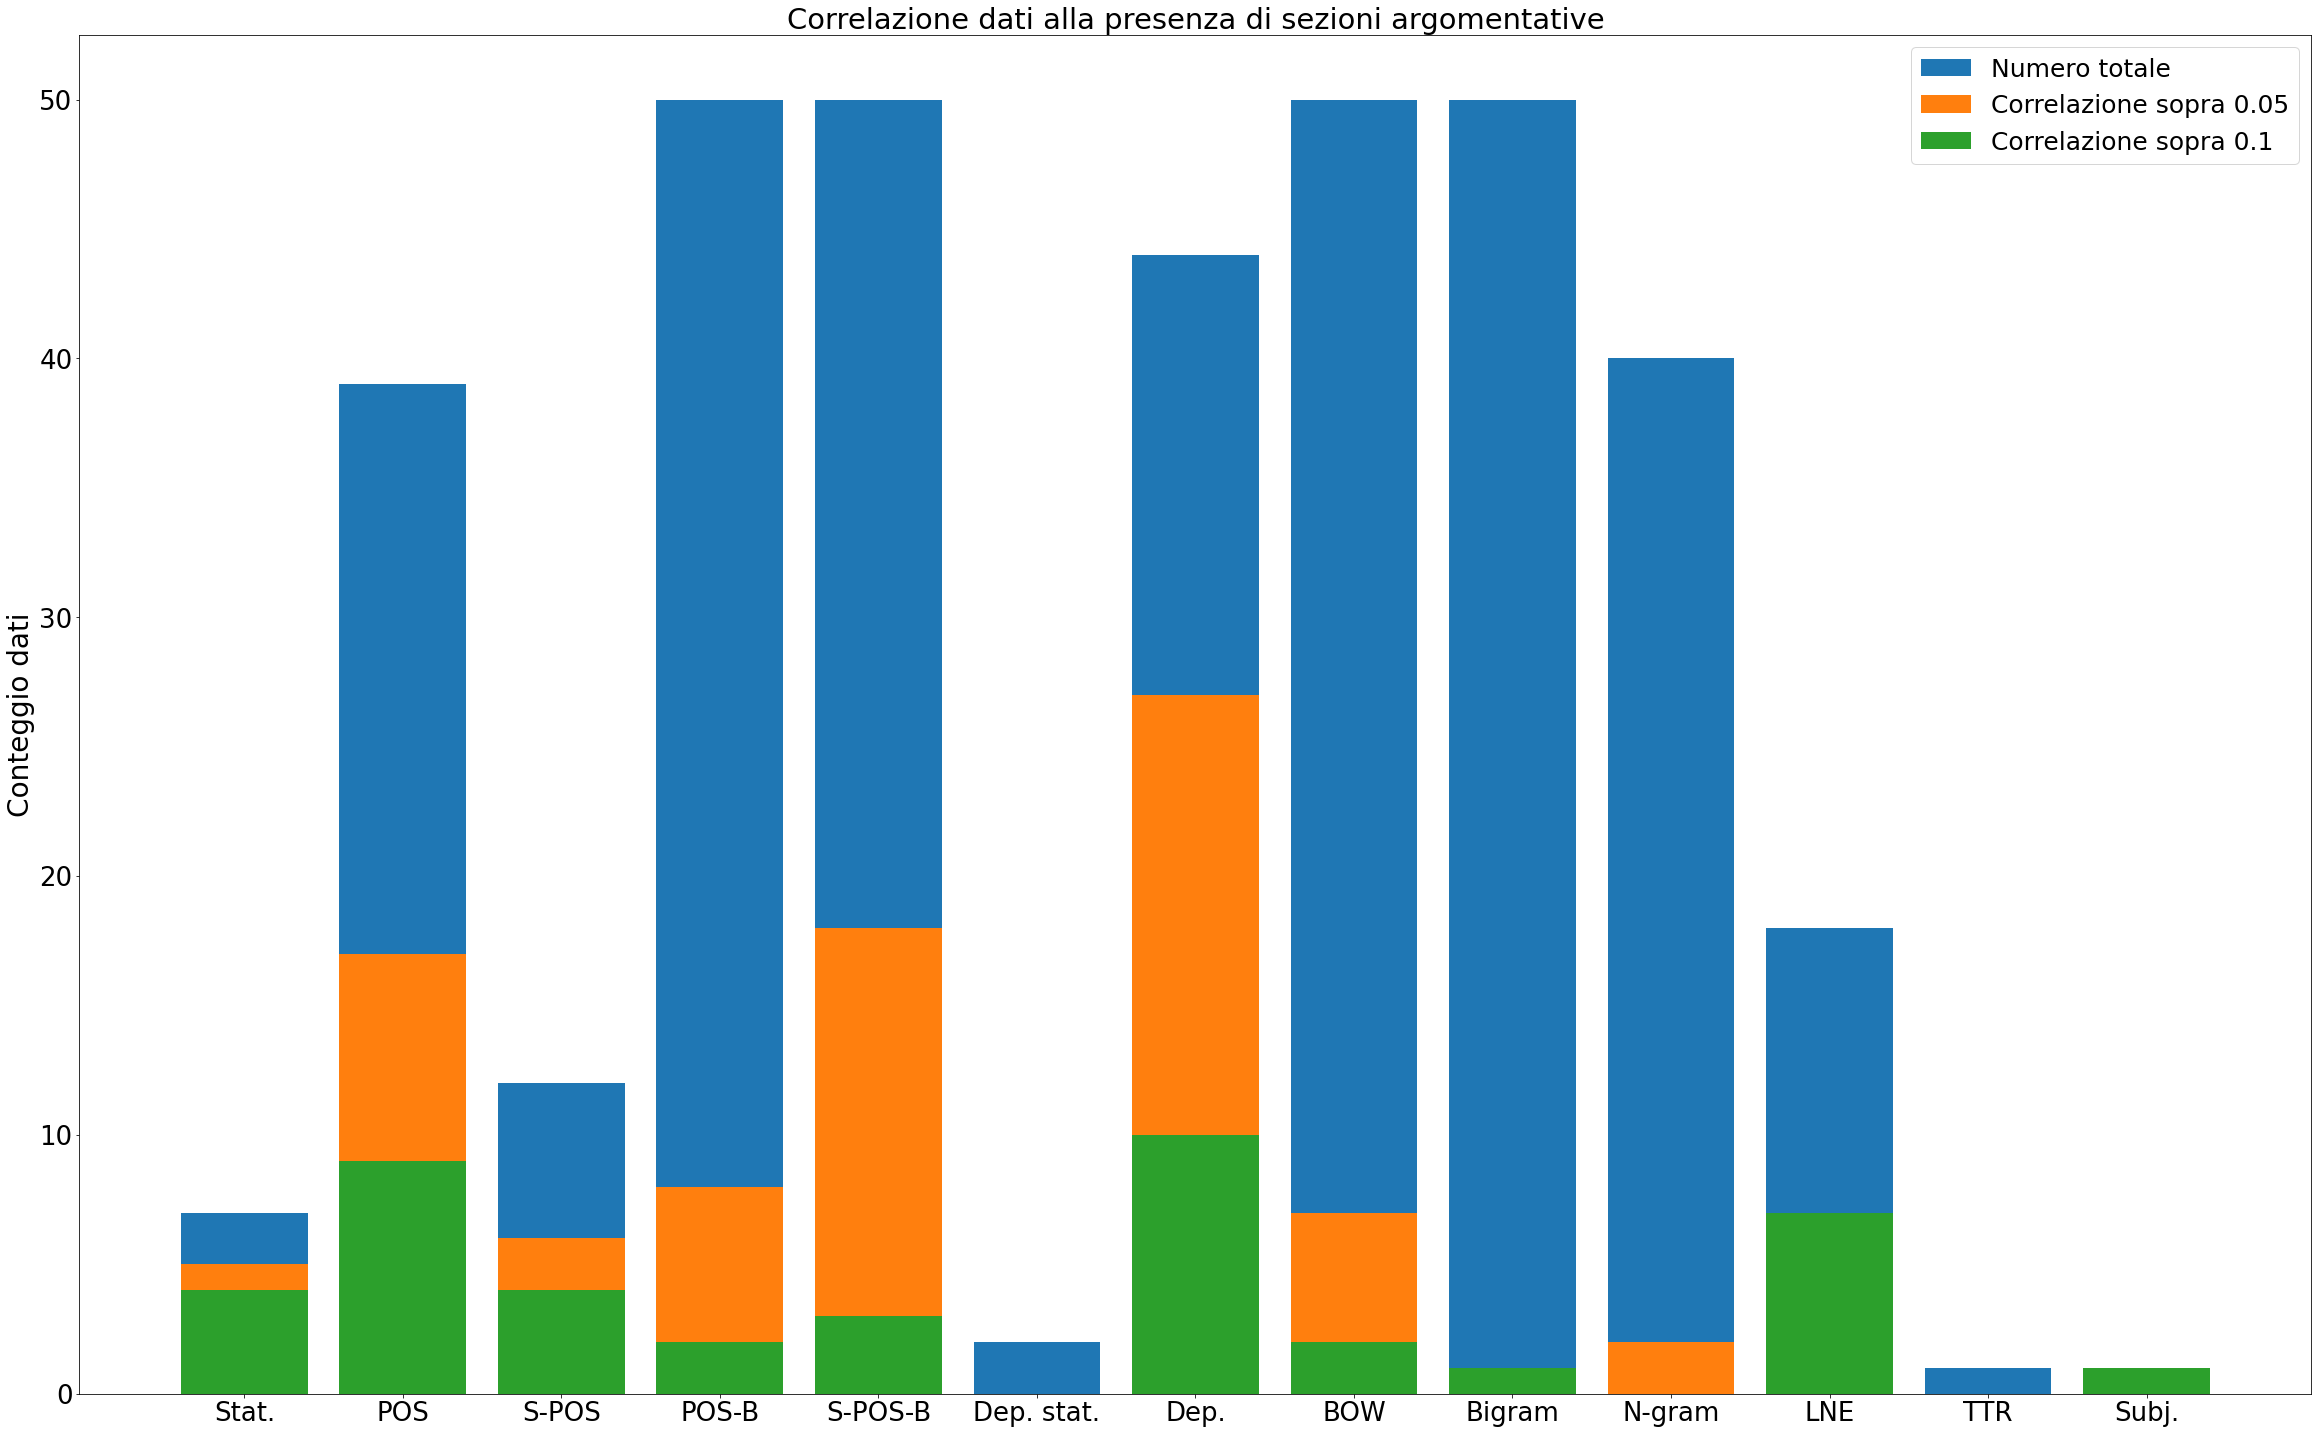

In [ ]:
# Obtain a visual representation of the type of data with the higher number of correlated 
# element to the argumentative sections and with the higher number of element in general.

fig, ax = plt.subplots(1, 1, figsize=(40, 25))
title='Correlazione dati alla presenza di sezioni argomentative'
count=[count_total,count_relevant_05,count_relevant_10]

    
ax.set_title('{}'.format(title), fontsize=29)
for i in range(3):
  ax.bar(data_group_names,count[i])
ax.legend(["Numero totale","Correlazione sopra 0.05","Correlazione sopra 0.1"],prop={'size': 25})
plt.ylabel('Conteggio dati', fontsize=28)
fig.show()